# Установка и подключение необходимых библиотек

In [ ]:
# Устанавливаем библиотеки
! pip install pandas scikit-learn nltk spacy
! python -m spacy download ru_core_news_sm

In [2]:
# Подключаем необходимые для работы библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gdown
import zipfile
import warnings
from google.colab import drive
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve, auc
import nltk
import spacy
import joblib

In [3]:
# Отключаем предупреждения
warnings.filterwarnings('ignore')

# Подготовка данных

In [4]:
# Монтируем Google-диск для скачивания ZIP-файла, распаковки и работы с CSV-файлом
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Сменим каталог с целью долгосрочного хранения данных
os.chdir('/content/drive/MyDrive')

In [6]:
# Задаем имя ZIP-файла с записями о контрактах
name_zip = 'fz.zip'

In [7]:
# Скачиваем ZIP-файл с записями о контрактах с Google-диска. Размер ZIP-файла - 2,3 Гб
url = 'https://drive.google.com/uc?id=1sRHx27O3NgTivrrQHdBdTAqxdCYNmARW'
gdown.download(url, name_zip, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1sRHx27O3NgTivrrQHdBdTAqxdCYNmARW
From (redirected): https://drive.google.com/uc?id=1sRHx27O3NgTivrrQHdBdTAqxdCYNmARW&confirm=t&uuid=53e2b021-e2f4-45e4-8638-1c7cc40e547e
To: /content/drive/MyDrive/fz.zip
100%|██████████| 2.47G/2.47G [00:36<00:00, 67.4MB/s]


'fz.zip'

In [8]:
# Распаковываем ZIP-файл с записями о контрактах. Размер CSV-файла - 26 Гб
with zipfile.ZipFile(name_zip, 'r') as zip_ref:
  zip_ref.extractall()

In [18]:
# Проверяем наличие CSV-файла в каталоге и присваиваем ему имя
name_csv = None
for file in os.listdir():
  if file.endswith('.csv'):
    name_csv = file
    break

if name_csv is None:
  raise FileNotFoundError("В ZIP-архиве CSV-файл не найден")

# Предобработка данных

In [20]:
df_original = pd.DataFrame()
# Определяем типы необходимых записей для анализа
type_cols = {'Subject': 'string', 'OKPD2': 'string'}
# Читаем данные из супербольшого CSV-файла в датафрейм кусками, одновременно удаляя ненужные для анализа столбцы и строки с пустыми значениями. В CSV-файле содержатся около 29 млн записей о контрактах, из них порядка 1,76 млн записей - нужных нам кодов ОКПД2
with pd.read_csv(name_csv, chunksize=100000, encoding='utf-8', on_bad_lines="skip", delimiter=',', header=None, usecols=[11, 26], names=['Subject', 'OKPD2'], dtype=type_cols) as reader:
  for chunk in reader:
    # Отфильтровываем записи о контрактах, оставляя записи групп ОКПД2 41, 42, 43, 71.1
    chunk = chunk[(chunk['OKPD2'].str.len() <= 4) & (chunk['OKPD2'].str.contains('^41.') | chunk['OKPD2'].str.contains('^42.') | chunk['OKPD2'].str.contains('^43.') | chunk['OKPD2'].str.contains('^71.1'))]
    # Удаляем из датафрейма строки с неопределенным предметом закупки и строки с пустыми значениями
    chunk = chunk.loc[chunk['Subject'] != '<НЕ ОПРЕДЕЛЕНО>']
    chunk.dropna
    # Добавляем текущий chunk в итоговый большой датафрейм
    df_original = pd.concat([df_original, chunk], ignore_index=True)

In [21]:
# Создаем рабочий датафрейм
df_work = df_original

In [22]:
# Сбрасываем индексы в датафрейме
df_work = df_work.reset_index()
del df_work['index']

# Предварительный анализ полученного датафрейма

In [23]:
# 10 случайных записей
df_work.sample(10)

,Subject,OKPD2
199918,Отсыпка дорог щебнем внутри села Ерыклы Новоше...,42.1
74144,Строительство автомобильной дороги с организац...,42.1
731248,Устройство инженерно-технических систем обеспе...,42.1
1228549,Выполнение работ по разработке проектной доку...,71.1
1239621,"Выполнение инженерных изысканий, разработка пр...",71.1
1297514,Выполнение работ по благоустройству территории...,43.1
1754396,"Благоустройство парка культуры и отдыха, ул. Л...",42.9
1290854,Текущий ремонт библиотек Государственного бюд...,41.2
299695,Капитальный ремонт помещения 1 этажа МБОУ СОШ ...,43.3
590236,Выполнение мероприятий по приведению образоват...,43.9


In [24]:
# Размерность
df_work.shape

(1764006, 2)

In [25]:
# Типы данных
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764006 entries, 0 to 1764005
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Subject  string
 1   OKPD2    string
dtypes: string(2)
memory usage: 26.9 MB


In [26]:
# Количество записей, сгруппированных по коду ОКПД2
df_work.groupby('OKPD2', as_index=False).agg({'Subject':'count'})

,OKPD2,Subject
0,41.1,12708
1,41.2,197730
2,42.1,386497
3,42.2,57455
4,42.9,110079
5,43.1,35840
6,43.2,311580
7,43.3,199705
8,43.9,200305
9,71.1,252107


# Выборка N случайных строк для анализа из всего датафрейма (затратим на анализ адекватное время)

In [27]:
n = 500000
df_work = df_work.sample(n)

# Лемматизация предмета закупки

In [28]:
# Загружаем русскую модель spaCy
nlp_Subject = spacy.load('ru_core_news_sm')

In [29]:
# Определим функцию для лемматизации предмета закупки
def lemmatize_Subject(text_Subject):
  doc = nlp_Subject(text_Subject)
  return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [30]:
# Лемматизируем столбец с предметом закупки - 500 тысяч записей обработались за 4 часа, 100 тысяч - за 40 минут
tqdm.pandas(desc="Выполняется лемматизация предмета закупки")
df_work['lemmatized_Subject_of_Contract'] = df_work['Subject'].progress_apply(lemmatize_Subject)

Выполняется лемматизация предмета закупки: 100%|██████████| 500000/500000 [3:30:27<00:00, 39.60it/s]


# Преобразование кодов ОКПД2 в текстовые метки и обратно

In [31]:
# Создадим словарь кодов ОКПД2 и соответствующих им рубрик классификатора
OKPD2_to_Labels = {
    '41.1': 'Документация проектная для строительства',
    '41.2': 'Здания и работы по возведению зданий',
    '42.1': 'Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог',
    '42.2': 'Сооружения и строительные работы по строительству инженерных коммуникаций',
    '42.9': 'Сооружения и строительные работы по строительству прочих гражданских сооружений',
    '43.1': 'Работы по сносу зданий и сооружений и по подготовке строительного участка',
    '43.2': 'Работы электромонтажные; работы по монтажу водопроводных и канализационных систем и прочие строительно-монтажные работы',
    '43.3': 'Работы завершающие и отделочные в зданиях и сооружениях',
    '43.9': 'Работы строительные специализированные прочие',
    '71.1': 'Услуги в области архитектуры; инженерно-технического проектирования и связанные технические консультативные услуги'
}

In [32]:
# Определим функцию для преобразования кодов ОКПД2 в текстовые метки рубрик классификатора
def convert_OKPD2_to_text_labels(code_OKPD2):
  return [OKPD2_to_Labels.get(c) for c in str(code_OKPD2).split(',') if c in OKPD2_to_Labels]

In [33]:
# Создадим словарь рубрик классификатора и соответствующих им кодов ОКПД2
Labels_to_OKPD2 = {v: k for k, v in OKPD2_to_Labels.items()}

In [34]:
# Промаркируем датафрейм метками рубрик
df_work['text_Labels'] = df_work['OKPD2'].apply(convert_OKPD2_to_text_labels)

# Преобразование текстовых меток в бинарный формат

In [38]:
# Для многоклассовой классификации используем бинарное представление текстовых меток рубрик
mlb_Labels = MultiLabelBinarizer()
y = mlb_Labels.fit_transform(df_work['text_Labels'])

# Разделение данных на обучающую и тестовую выборки

In [39]:
# Зададим размер обучающей выборки в 80%, тестовой выборки - 20%
X_train, X_test, y_train, y_test = train_test_split(df_work['lemmatized_Subject_of_Contract'], y, test_size=0.2, random_state=42)

# Создание модели обучения

In [40]:
# Используем TfidfVectorizer для преобразования текста в числовые вектора
tfidf = TfidfVectorizer(max_features=10000)

In [41]:
# Используем метод логистической регрессии. На выборке 500 тысяч записей модель обучается за 3 минуты
model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
# Используем случайный лес. На выборке 500 тысяч записей модель обучается за 4 часа
# model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
# Используем градиентный бустинг. На выборке 500 тысяч записей модель обучается за 1 час
# model = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=100, random_state=42))
# Используем метод опорных векторов. На выборке 500 тысяч записей модель обучается за 4,5 минуты
# model = OneVsRestClassifier(CalibratedClassifierCV(LinearSVC()))
# Используем наивный байесовский классификатор. На выборке 500 тысяч записей модель обучается за 13 секунд
# model = OneVsRestClassifier(MultinomialNB())
# Используем XGBoost. На выборке 500 тысяч записей модель обучается за 12 минут
# model = MultiOutputClassifier(XGBClassifier(n_estimators=100, random_state=42))
# Используем нейронные сети. На выборке 500 тысяч записей модель обучается за 3 часа
# model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(10), max_iter=100, random_state=42))

In [42]:
# Построим пайплайн модели обучения
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clsf', model)
])

# Обучение модели на обучающей выборке

In [43]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('clsf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

# Оценка модели

In [44]:
# На обучающей выборке
train_predictions = pipeline.predict(X_train)
train_report = classification_report(y_train, train_predictions, target_names=mlb_Labels.classes_)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Метрики оценки качества на обучающей выборке:")
print(train_report)
print(f"Точность (Accuracy) на обучающей выборке равна {train_accuracy:.2f}")

Метрики оценки качества на обучающей выборке:
                                                                                                                         precision    recall  f1-score   support

                                                                               Документация проектная для строительства       0.31      0.05      0.08      2830
             Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог       0.93      0.90      0.92     87923
                                                                                   Здания и работы по возведению зданий       0.86      0.52      0.65     45005
                                                                Работы завершающие и отделочные в зданиях и сооружениях       0.75      0.59      0.66     45050
                                              Работы по сносу зданий и сооружений и по подготовке строительного участка       0.92      0.59      0.

In [45]:
# На тестовой выборке
test_predictions = pipeline.predict(X_test)
test_report = classification_report(y_test, test_predictions, target_names=mlb_Labels.classes_)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Метрики оценки качества на тестовой выборке:")
print(test_report)
print(f"Точность (Accuracy) на тестовой выборке равна {test_accuracy:.2f}")

Метрики оценки качества на тестовой выборке:
                                                                                                                         precision    recall  f1-score   support

                                                                               Документация проектная для строительства       0.19      0.03      0.05       683
             Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог       0.93      0.90      0.91     21822
                                                                                   Здания и работы по возведению зданий       0.85      0.51      0.64     11190
                                                                Работы завершающие и отделочные в зданиях и сооружениях       0.73      0.56      0.64     11482
                                              Работы по сносу зданий и сооружений и по подготовке строительного участка       0.92      0.58      0.7

# Построение ROC-кривой и вычисление AUC

In [46]:
# Определим функцию для вывода кривой ROC и показателя AUC
def draw_roc_auc(y_true, y_pred, title):
  fig, ax = plt.subplots(figsize=(8, 6))
  for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    auc_score = roc_auc_score(y_true[:, i], y_pred[:, i])
    label = f'{mlb_Labels.classes_[i]} (ОКПД2: {Labels_to_OKPD2[mlb_Labels.classes_[i]]}) (AUC = {auc_score:.2f})'
    ax.plot(fpr, tpr, label=label)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(title)
  ax.legend(bbox_to_anchor=(-0.1, -0.1), loc='upper left', prop={'size': 7})
  plt.show()

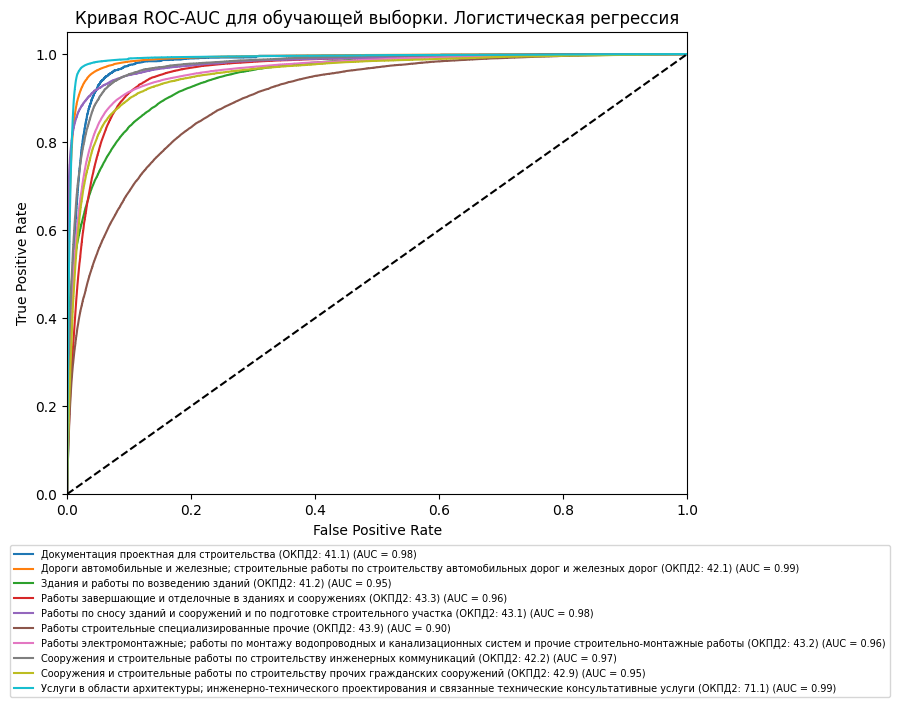

In [47]:
# Кривая ROC-AUC для обучающей выборки
# train_probabilities = pipeline.predict_proba(X_train) # график для SVM и NB
train_probabilities = np.array([x[:, 1] for x in pipeline.predict_proba(X_train)]).T # график для других моделей
draw_roc_auc(y_train, train_probabilities, 'Кривая ROC-AUC для обучающей выборки. Логистическая регрессия')

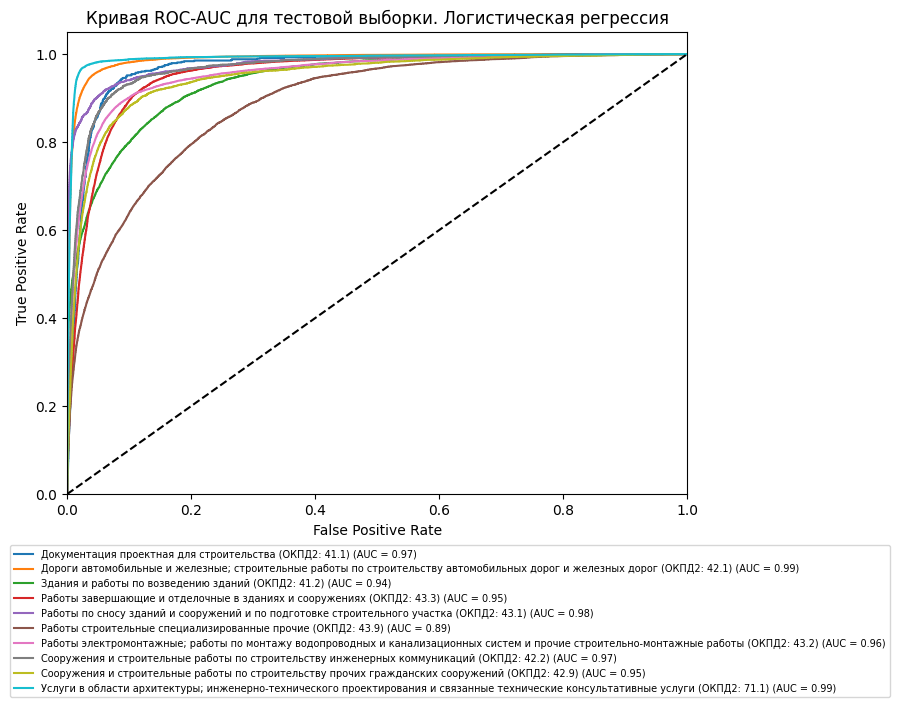

In [48]:
# Кривая ROC-AUC для тестовой выборки
# test_probabilities = pipeline.predict_proba(X_test) # график для SVM и NB
test_probabilities = np.array([x[:, 1] for x in pipeline.predict_proba(X_test)]).T # график для других моделей
draw_roc_auc(y_test, test_probabilities, 'Кривая ROC-AUC для тестовой выборки. Логистическая регрессия')

# Сохранение модели

In [49]:
joblib.dump(pipeline, 'fz_classification_model.pkl')

['fz_classification_model.pkl']

# Применение модели

In [50]:
# Загружаем сохраненную модель
pipeline = joblib.load('fz_classification_model.pkl')

In [51]:
# Определим функцию для классификации нового контракта
def classify_new_contract(Subject_of_new_contract):
  lemmatized_Subject = lemmatize_Subject(Subject_of_new_contract)
  prediction = pipeline.predict([lemmatized_Subject])
  labels = mlb_Labels.inverse_transform(prediction)
  return labels[0]

# Пример использования

Тестовые наименования предмета контракта с верными кодами ОКПД2 для проверки:
*   Выполнение работ по проектированию строительства дома - 41.1
*   Приобретение жилого помещения для нуждающихся - 41.2
*   Ремонт моста - 42.1
*   Выполнение работ по текущему  ремонту трубопровода - 42.2
*   Обустройство детской игровой площадки - 42.9
*   Разбор ветхих объектов на территории поселка - 43.1
*   Выполнение работ по ремонту системы вытяжной вентиляции - 43.2
*   Выполнение работ по ремонту помещений - 43.3
*   Выполнение работ по капитальному ремонту кровли - 43.9
*   Выполнение геодезических и кадастровых работ - 71.1













In [55]:
new_contract = input("Введите предмет закупки: ")
predicted_Subject = classify_new_contract(new_contract)
if len(predicted_Subject) != 0:
  for key in Labels_to_OKPD2:
    if key == predicted_Subject[0]:
      predicted_OKPD2 = Labels_to_OKPD2[key]
      print(f"Результат классификации: ОКПД2 - {predicted_OKPD2}, рубрика - {predicted_Subject[0]}")
else: print(f"Предмет закупки '{new_contract}' не классифицирован")

Введите предмет закупки: Обустройство детской игровой площадки
Результат классификации: ОКПД2 - 42.9, рубрика - Сооружения и строительные работы по строительству прочих гражданских сооружений
